<a id='0'></a>
## <p style="background-color:#fdb913; font-family:Computer Modern;src: url('http://mirrors.ctan.org/fonts/cm-unicode/fonts/otf/cmunss.otf'); font-size:100%; text-align:center"> Time Series Anomaly/Outliers Detection on IPL cricket game data</p>
`
<div align="center">
    <img src="https://user-images.githubusercontent.com/48846576/166569679-1faac713-2775-4cc8-8ab2-36509f5e5d6c.jpg"> 
</div>

<h2>Table of contents</h2>

<a id='0'></a>

* [Overview](#overview)
* [Methodology](#method)        
* [Isolation Forest](#iforest)        
* [Load Data](#data)
* [Sample IPL Game Time Series](#sample_ts)
* [Outlier Detection using PyCaret](#pycaret)
* [Outliers Detection Excercise for all IPL 2022 Games](#outlier-detect)
    * [Chennai Super Kings](#csk)
    * [Delhi Capitals](#dc)
    * [Gujarat Titans](#gt)
    * [Kolkata Knight Riders](#kkr)
    * [Lucknow Super Giants](#lsg)
    * [Mumbai Indians](#mi)
    * [Punjab Kings](#pbks)
    * [Rajasthan Royals](#rr)
    * [Royal Challengers Bangalore](#rcb)
    * [Sunrisers Hyderabad](#srh)
* [Conclusion](#conclusion)    

<a id='overview'></a>
# Overview
[back to top](#0)

This notebook performs anomaly/outliers detection on Indian Premier League T20 (IPL T20) Cricket Matches. A cricket game can be viewed as a time series data. There are two time series in a given cricket game (one for each team). Anomaly detection is a process to identify data points that deviate from the normal tendency of the dataset. The anomalous data in the context of a cricket game represent critical events in the game such as a boundary scored (4 or 6 runs), catch dropped, misfielding, no balls/wide that result in extra delivery, DRS reviews, etc.

<a id='method'></a>
# Methodology
[back to top](#0)

<div align="left">
    <img src="https://user-images.githubusercontent.com/48846576/166571986-74a8b0b2-fcc0-413b-8a8d-43345cc40ee6.jpg"> 
</div>

* Each T20 cricket game has two innings. The game starts with coin toss where the team that wins the toss chooses to bat first or bat second (bowl first)
* A typical game will have around 120 deliveries (divided into 20 overs with each over consists of 6 legal balls/deliveries that a bowler has to bowl). The number will go up depending on the extra deliveries that bowlers have to bowl due to  illegal deliveries judged by the umpiers. The number may come down if all the batsman in the batting team get out before the completion of their innings
* Each delivery/ball bowled can be viewed as a unit of time with the result of the delivery as the outcome. Hence every delivery will have many attributes associated to it like the batsman, bowler, delivery number, over number, innings, venue, legal delivery or not and many others. There will also be commentary associated to each delivery which is a textual description of the play.
* The goal is to pre-process this time series data, create features, identify clusters from commentary text and feed the data to PyCaret's Isolation Forest algorithm and Visualize the outcome. 
* This is a unsupervised algorithm where there are no labeld outliers available. Hence the important parameter is the contamination parameter to the Isoaltion Forest model which indicates the % of outliers that we expect from the given data


<a id='iforest'></a>
# Isolation Forest
[back to top](#0)


Isolation forest is an ensemble learning algorithm, effectively used in time series anomaly detection. It can be used a unsupervised setting which does not rely on prior labeling of the outliers. Its based on the fact that the anomalous data are "few and different" data points in the given dataset. In this algorithm a random sub-sample of the data is obtained from the original dataset and a decision tree is built based on random cuts in values of randomly selected features of the data. The samples that take many branches to reach the leaf node are less likely to be outliers while the samples that take shorter branches may indicate outliers.

The figure below shows how the cuts are done by the Isolation Forest algorithm. Fig (a) shows that the red point (anomalous data) is isolated in three random cuts where as Fig (b) shows the same process for the normal data point. Since the normal point is deep inside teh data it takes many cuts to isolate that data point. The numbers on the lines represnent the order of tree branching process.

<div align="left">
    <img src="https://user-images.githubusercontent.com/48846576/166577211-396c5e0f-63e5-4f17-884f-18183e78ee6b.png"><br> 
    Source: <a href="https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8888179">IEEE - Extended Isolation Forest</a>
</div>


References

* [Time Series Anomaly Detection with PyCaret](https://towardsdatascience.com/time-series-anomaly-detection-with-pycaret-706a6e2b2427)
* [Anomaly detection using Isolation Forest – A Complete Guide](https://www.analyticsvidhya.com/blog/2021/07/anomaly-detection-using-isolation-forest-a-complete-guide/)
* [IEEE - Extended Isolation Forest](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8888179)


In [1]:
import numpy as np
import pandas as pd
import os
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
import plotly.io as pio
from plotly.subplots import make_subplots
# setting default template to plotly_white for all visualizations
pio.templates.default = "plotly_dark"
%matplotlib inline
import gc

from colorama import Fore, Back, Style

y_ = Fore.YELLOW
r_ = Fore.RED
g_ = Fore.GREEN
b_ = Fore.BLUE
m_ = Fore.MAGENTA
c_ = Fore.CYAN
res = Style.RESET_ALL

import warnings
warnings.filterwarnings('ignore')
import folium
import matplotlib.dates as mdates
from datetime import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.offsetbox import AnchoredText
import matplotlib
YELLOVE = '#fdb913'   

***Install pycaret***

In [2]:
!pip install pycaret

     |████████████████████████████████| 320 kB 620 kB/s            
     |████████████████████████████████| 6.8 MB 9.3 MB/s            
     |████████████████████████████████| 167 kB 51.3 MB/s            
     |████████████████████████████████| 10.4 MB 38.9 MB/s            
     |████████████████████████████████| 118 kB 69.5 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 636 kB 52.0 MB/s            
     |████████████████████████████████| 25.9 MB 48.3 MB/s            
     |████████████████████████████████| 24.2 MB 54.4 MB/s            
     |████████████████████████████████| 16.8 MB 47.0 MB/s            
     |████████████████████████████████| 184 kB 42.2 MB/s            
     |████████████████████████████████| 1.0 MB 60.6 MB/s            
     |████████████████████████████████| 271 kB 69.0 MB/s            
     |████████████████████████████████| 14.8 MB 38.1 MB/s            
     |████████████████████████████████| 62 kB 509 kB/s 

In [3]:
#Define custom plotly template
pio.templates["my_plotly_template"] = go.layout.Template(
    # LAYOUT
    layout = {'annotationdefaults': {'arrowcolor': '#f2f5fa', 'arrowhead': 0, 'arrowwidth': 1},
               'autotypenumbers': 'strict',
               'coloraxis': {'colorbar': {'outlinewidth': 0, 'ticks': ''}},
               'colorscale': {'diverging': [[0, '#8e0152'], [0.1, '#c51b7d'],
                                            [0.2, '#de77ae'], [0.3, '#f1b6da'],
                                            [0.4, '#fde0ef'], [0.5, '#f7f7f7'],
                                            [0.6, '#e6f5d0'], [0.7, '#b8e186'],
                                            [0.8, '#7fbc41'], [0.9, '#4d9221'], [1,
                                            '#276419']],
                              'sequential': [[0.0, '#0d0887'],
                                             [0.1111111111111111, '#46039f'],
                                             [0.2222222222222222, '#7201a8'],
                                             [0.3333333333333333, '#9c179e'],
                                             [0.4444444444444444, '#bd3786'],
                                             [0.5555555555555556, '#d8576b'],
                                             [0.6666666666666666, '#ed7953'],
                                             [0.7777777777777778, '#fb9f3a'],
                                             [0.8888888888888888, '#fdca26'], [1.0,
                                             '#f0f921']],
                              'sequentialminus': [[0.0, '#0d0887'],
                                                  [0.1111111111111111, '#46039f'],
                                                  [0.2222222222222222, '#7201a8'],
                                                  [0.3333333333333333, '#9c179e'],
                                                  [0.4444444444444444, '#bd3786'],
                                                  [0.5555555555555556, '#d8576b'],
                                                  [0.6666666666666666, '#ed7953'],
                                                  [0.7777777777777778, '#fb9f3a'],
                                                  [0.8888888888888888, '#fdca26'],
                                                  [1.0, '#f0f921']]},
               'colorway': ['#636efa', '#EF553B', '#00cc96', '#ab63fa', '#FFA15A', '#19d3f3',
                            '#FF6692', '#B6E880', '#FF97FF', '#FECB52'],
               'font': {'color': '#f2f5fa'},
               'geo': {'bgcolor': 'rgb(17,17,17)',
                       'lakecolor': 'rgb(17,17,17)',
                       'landcolor': 'rgb(17,17,17)',
                       'showlakes': True,
                       'showland': True,
                       'subunitcolor': '#506784'},
               'hoverlabel': {'align': 'left'},
               'hovermode': 'closest',
               'mapbox': {'style': 'dark'},
               'paper_bgcolor': '#666666',
               'plot_bgcolor': '#666666',
               'polar': {'angularaxis': {'gridcolor': '#506784', 'linecolor': '#506784', 'ticks': ''},
                         'bgcolor': 'rgb(17,17,17)',
                         'radialaxis': {'gridcolor': '#506784', 'linecolor': '#506784', 'ticks': ''}},
               'scene': {'xaxis': {'backgroundcolor': 'rgb(17,17,17)',
                                   'gridcolor': '#506784',
                                   'gridwidth': 2,
                                   'linecolor': '#506784',
                                   'showbackground': True,
                                   'ticks': '',
                                   'zerolinecolor': '#C8D4E3'},
                         'yaxis': {'backgroundcolor': 'rgb(17,17,17)',
                                   'gridcolor': '#506784',
                                   'gridwidth': 2,
                                   'linecolor': '#506784',
                                   'showbackground': True,
                                   'ticks': '',
                                   'zerolinecolor': '#C8D4E3'},
                         'zaxis': {'backgroundcolor': 'rgb(17,17,17)',
                                   'gridcolor': '#506784',
                                   'gridwidth': 2,
                                   'linecolor': '#506784',
                                   'showbackground': True,
                                   'ticks': '',
                                   'zerolinecolor': '#C8D4E3'}},
               'shapedefaults': {'line': {'color': '#f2f5fa'}},
               'sliderdefaults': {'bgcolor': '#C8D4E3', 'bordercolor': 'rgb(17,17,17)', 'borderwidth': 1, 'tickwidth': 0},
               'ternary': {'aaxis': {'gridcolor': '#506784', 'linecolor': '#506784', 'ticks': ''},
                           'baxis': {'gridcolor': '#506784', 'linecolor': '#506784', 'ticks': ''},
                           'bgcolor': 'rgb(17,17,17)',
                           'caxis': {'gridcolor': '#506784', 'linecolor': '#506784', 'ticks': ''}},
               'title': {'x': 0.05},
               'updatemenudefaults': {'bgcolor': '#506784', 'borderwidth': 0},
               'xaxis': {'automargin': True,
                         'gridcolor': '#283442',
                         'linecolor': '#506784',
                         'ticks': '',
                         'title': {'standoff': 15},
                         'zerolinecolor': '#283442',
                         'zerolinewidth': 2},
               'yaxis': {'automargin': True,
                         'gridcolor': '#283442',
                         'linecolor': '#506784',
                         'ticks': '',
                         'title': {'standoff': 15},
                         'zerolinecolor': '#283442',
                         'zerolinewidth': 2}},
    data = {'bar': [{'error_x': {'color': '#f2f5fa'},
                      'error_y': {'color': '#f2f5fa'},
                      'marker': {'line': {'color': 'rgb(17,17,17)', 'width': 0.5},
                                 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}},
                      'type': 'bar'}],
             'barpolar': [{'marker': {'line': {'color': 'rgb(17,17,17)', 'width': 0.5},
                                      'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}},
                           'type': 'barpolar'}],
             'carpet': [{'aaxis': {'endlinecolor': '#A2B1C6',
                                   'gridcolor': '#506784',
                                   'linecolor': '#506784',
                                   'minorgridcolor': '#506784',
                                   'startlinecolor': '#A2B1C6'},
                         'baxis': {'endlinecolor': '#A2B1C6',
                                   'gridcolor': '#506784',
                                   'linecolor': '#506784',
                                   'minorgridcolor': '#506784',
                                   'startlinecolor': '#A2B1C6'},
                         'type': 'carpet'}],
             'choropleth': [{'colorbar': {'outlinewidth': 0, 'ticks': ''}, 'type': 'choropleth'}],
             'contour': [{'colorbar': {'outlinewidth': 0, 'ticks': ''},
                          'colorscale': [[0.0, '#0d0887'], [0.1111111111111111,
                                         '#46039f'], [0.2222222222222222,
                                         '#7201a8'], [0.3333333333333333,
                                         '#9c179e'], [0.4444444444444444,
                                         '#bd3786'], [0.5555555555555556,
                                         '#d8576b'], [0.6666666666666666,
                                         '#ed7953'], [0.7777777777777778,
                                         '#fb9f3a'], [0.8888888888888888,
                                         '#fdca26'], [1.0, '#f0f921']],
                          'type': 'contour'}],
             'contourcarpet': [{'colorbar': {'outlinewidth': 0, 'ticks': ''}, 'type': 'contourcarpet'}],
             'heatmap': [{'colorbar': {'outlinewidth': 0, 'ticks': ''},
                          'colorscale': [[0.0, '#0d0887'], [0.1111111111111111,
                                         '#46039f'], [0.2222222222222222,
                                         '#7201a8'], [0.3333333333333333,
                                         '#9c179e'], [0.4444444444444444,
                                         '#bd3786'], [0.5555555555555556,
                                         '#d8576b'], [0.6666666666666666,
                                         '#ed7953'], [0.7777777777777778,
                                         '#fb9f3a'], [0.8888888888888888,
                                         '#fdca26'], [1.0, '#f0f921']],
                          'type': 'heatmap'}],
             'heatmapgl': [{'colorbar': {'outlinewidth': 0, 'ticks': ''},
                            'colorscale': [[0.0, '#0d0887'], [0.1111111111111111,
                                           '#46039f'], [0.2222222222222222,
                                           '#7201a8'], [0.3333333333333333,
                                           '#9c179e'], [0.4444444444444444,
                                           '#bd3786'], [0.5555555555555556,
                                           '#d8576b'], [0.6666666666666666,
                                           '#ed7953'], [0.7777777777777778,
                                           '#fb9f3a'], [0.8888888888888888,
                                           '#fdca26'], [1.0, '#f0f921']],
                            'type': 'heatmapgl'}],
             'histogram': [{'marker': {'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}},
                            'type': 'histogram'}],
             'histogram2d': [{'colorbar': {'outlinewidth': 0, 'ticks': ''},
                              'colorscale': [[0.0, '#0d0887'],
                                             [0.1111111111111111, '#46039f'],
                                             [0.2222222222222222, '#7201a8'],
                                             [0.3333333333333333, '#9c179e'],
                                             [0.4444444444444444, '#bd3786'],
                                             [0.5555555555555556, '#d8576b'],
                                             [0.6666666666666666, '#ed7953'],
                                             [0.7777777777777778, '#fb9f3a'],
                                             [0.8888888888888888, '#fdca26'], [1.0,
                                             '#f0f921']],
                              'type': 'histogram2d'}],
             'histogram2dcontour': [{'colorbar': {'outlinewidth': 0, 'ticks': ''},
                                     'colorscale': [[0.0, '#0d0887'],
                                                    [0.1111111111111111,
                                                    '#46039f'],
                                                    [0.2222222222222222,
                                                    '#7201a8'],
                                                    [0.3333333333333333,
                                                    '#9c179e'],
                                                    [0.4444444444444444,
                                                    '#bd3786'],
                                                    [0.5555555555555556,
                                                    '#d8576b'],
                                                    [0.6666666666666666,
                                                    '#ed7953'],
                                                    [0.7777777777777778,
                                                    '#fb9f3a'],
                                                    [0.8888888888888888,
                                                    '#fdca26'], [1.0, '#f0f921']],
                                     'type': 'histogram2dcontour'}],
             'mesh3d': [{'colorbar': {'outlinewidth': 0, 'ticks': ''}, 'type': 'mesh3d'}],
             'parcoords': [{'line': {'colorbar': {'outlinewidth': 0, 'ticks': ''}}, 'type': 'parcoords'}],
             'pie': [{'automargin': True, 'type': 'pie'}],
             'scatter': [{'marker': {'line': {'color': '#283442'}}, 'type': 'scatter'}],
             'scatter3d': [{'line': {'colorbar': {'outlinewidth': 0, 'ticks': ''}},
                            'marker': {'colorbar': {'outlinewidth': 0, 'ticks': ''}},
                            'type': 'scatter3d'}],
             'scattercarpet': [{'marker': {'colorbar': {'outlinewidth': 0, 'ticks': ''}}, 'type': 'scattercarpet'}],
             'scattergeo': [{'marker': {'colorbar': {'outlinewidth': 0, 'ticks': ''}}, 'type': 'scattergeo'}],
             'scattergl': [{'marker': {'line': {'color': '#283442'}}, 'type': 'scattergl'}],
             'scattermapbox': [{'marker': {'colorbar': {'outlinewidth': 0, 'ticks': ''}}, 'type': 'scattermapbox'}],
             'scatterpolar': [{'marker': {'colorbar': {'outlinewidth': 0, 'ticks': ''}}, 'type': 'scatterpolar'}],
             'scatterpolargl': [{'marker': {'colorbar': {'outlinewidth': 0, 'ticks': ''}}, 'type': 'scatterpolargl'}],
             'scatterternary': [{'marker': {'colorbar': {'outlinewidth': 0, 'ticks': ''}}, 'type': 'scatterternary'}],
             'surface': [{'colorbar': {'outlinewidth': 0, 'ticks': ''},
                          'colorscale': [[0.0, '#0d0887'], [0.1111111111111111,
                                         '#46039f'], [0.2222222222222222,
                                         '#7201a8'], [0.3333333333333333,
                                         '#9c179e'], [0.4444444444444444,
                                         '#bd3786'], [0.5555555555555556,
                                         '#d8576b'], [0.6666666666666666,
                                         '#ed7953'], [0.7777777777777778,
                                         '#fb9f3a'], [0.8888888888888888,
                                         '#fdca26'], [1.0, '#f0f921']],
                          'type': 'surface'}],
             'table': [{'cells': {'fill': {'color': '#506784'}, 'line': {'color': 'rgb(17,17,17)'}},
                        'header': {'fill': {'color': '#2a3f5f'}, 'line': {'color': 'rgb(17,17,17)'}},
                        'type': 'table'}]}
)

<a id='data'></a>
# Load Data
[back to top](#0)

In [4]:
summary_22 = pd.read_csv('/kaggle/input/indian-premier-league-ipl-all-seasons/2022/season_summary.csv', index_col=None)
details_22 = pd.read_csv('/kaggle/input/indian-premier-league-ipl-all-seasons/2022/season_details.csv', index_col=None)
details_22['match_id'] = details_22['match_id'].astype(int)
details_22['comment_id'] = details_22['comment_id'].astype(int)

In [5]:
#Ball by Ball data
details_22[['home_team','away_team','current_innings', 'innings_id','over','ball','runs','batsman1_name','bowler1_name','isBoundary','isWide','isNoball','batsman1_runs', 'batsman1_balls','bowler1_overs','bowler1_runs']].head(20)

home_team away_team current_innings  innings_id  over  ball  runs  \
0         DC        RR              RR           1     1     1     0   
1         DC        RR              RR           1     1     2     0   
2         DC        RR              RR           1     1     3     0   
3         DC        RR              RR           1     1     4     4   
4         DC        RR              RR           1     1     5     0   
5         DC        RR              RR           1     1     6     4   
6         DC        RR              RR           1     2     1     0   
7         DC        RR              RR           1     2     2     1   
8         DC        RR              RR           1     2     3     0   
9         DC        RR              RR           1     2     4     0   
10        DC        RR              RR           1     2     5     0   
11        DC        RR              RR           1     2     6     0   
12        DC        RR              RR           1     3     1     0   
13        DC        RR              RR           1     3     2     1   
14        DC        RR              RR           1     3     3     1   
15        DC        RR              RR           1     3     4     0   
16        DC        RR              RR           1     3     5     0   
17        DC        RR              RR           1     3     6     1   
18        DC        RR              RR           1     4     1     2   
19        DC        RR              RR           1     4     2     4   

       batsman1_name       bowler1_name  isBoundary  isWide  isNoball  \
0        Jos Buttler      Khaleel Ahmed       False   False     False   
1        Jos Buttler      Khaleel Ahmed       False   False     False   
2        Jos Buttler      Khaleel Ahmed       False   False     False   
3        Jos Buttler      Khaleel Ahmed        True   False     False   
4        Jos Buttler      Khaleel Ahmed       False   False     False   
5        Jos Buttler      Khaleel Ahmed        True   False     False   
6   Devdutt Padikkal     Shardul Thakur       False   False     False   
7   Devdutt Padikkal     Shardul Thakur       False   False     False   
8        Jos Buttler     Shardul Thakur       False   False     False   
9        Jos Buttler     Shardul Thakur       False   False     False   
10       Jos Buttler     Shardul Thakur       False   False     False   
11       Jos Buttler     Shardul Thakur       False   False     False   
12  Devdutt Padikkal        Lalit Yadav       False   False     False   
13  Devdutt Padikkal        Lalit Yadav       False   False     False   
14       Jos Buttler        Lalit Yadav       False   False     False   
15  Devdutt Padikkal        Lalit Yadav       False   False     False   
16  Devdutt Padikkal        Lalit Yadav       False   False     False   
17  Devdutt Padikkal        Lalit Yadav       False   False     False   
18  Devdutt Padikkal  Mustafizur Rahman       False   False     False   
19  Devdutt Padikkal  Mustafizur Rahman        True   False     False   

    batsman1_runs  batsman1_balls  bowler1_overs  bowler1_runs  
0               0               1            0.1             0  
1               0               2            0.2             0  
2               0               3            0.3             0  
3               4               4            0.4             4  
4               4               5            0.5             4  
5               8               6            1.0             8  
6               0               1            0.1             0  
7               0               2            0.2             0  
8               8               7            0.3             0  
9               8               8            0.4             0  
10              8               9            0.5             0  
11              8              10            1.0             0  
12              0               3            0.1             0  
13              1               4            0

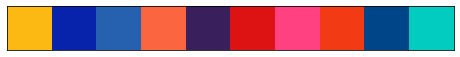

In [6]:
def get_innings_df(match_id, innings):
    innings_df = details_22.loc[(details_22['match_id'] == match_id) & (details_22['current_innings'] == innings)].reset_index(drop=True).sort_values(by="comment_id").reset_index(drop=True)
    innings_df['text'] = innings_df['text'].fillna('')
    innings_df['preText'] = innings_df['preText'].fillna('')    
    innings_df['postText'] = innings_df['postText'].fillna('')   
    innings_df['wicket_id'] = innings_df['wicket_id'].fillna(0)
    innings_df['wicket_id'] = innings_df['wicket_id'].astype(int)
    return innings_df

def ipl_teams_color_palette(custom_colors):
    customPalette = sns.set_palette(sns.color_palette(custom_colors))
    sns.palplot(sns.color_palette(custom_colors),size=0.8)
    plt.tick_params(axis='both', labelsize=0, length = 0)

team_colors = { 'CSK' : '#fdb913',
'MI' : '#0722ab',
'DC' : '#2561AE',
'SRH' : '#fb653f',
'KKR' : '#391F5C',
'PBKS' : '#dd1212',
'RR' : '#FF4081',
'RCB' : '#F23B14',
'GT' : '#004587',
'LSG' : '#02ccbf'}
ipl_teams_color_palette(team_colors.values())


In [7]:
from string import punctuation
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from pycaret.anomaly import *
import textwrap
from plotly.subplots import make_subplots

def draw_time_series(match_id, match_name, toss_won, decision):
    
    COLS = ['home_team','away_team','current_innings', 'innings_id','over','ball','runs','batsman1_name','bowler1_name','isBoundary','isWide','isNoball','batsman1_runs', 'batsman1_balls','bowler1_overs','bowler1_runs', 'text_cluster','isOut']    
    output = {}
    background_color = '#757575'
    match_id = match_id
    innings = match_name.split('v')
    pio.templates.default = "my_plotly_template"
    
    team1 = innings[0].strip()
    team2 = innings[1].strip()
    first_inning = None
    second_inning = None    
    innings = []
    if toss_won == team1 and decision == 'BOWL FIRST':
        first_inning = team2
        second_inning = team1
    elif toss_won == team1 and decision == 'BAT FIRST':    
        first_inning = team1
        second_inning = team2
    elif toss_won == team2 and decision == 'BAT FIRST':    
        first_inning = team2
        second_inning = team1
    else:
        first_inning = team1
        second_inning = team2
        
    innings = [first_inning, second_inning]
    fig = make_subplots(rows=2, cols=1,
                   subplot_titles = innings,
                    shared_xaxes=True,
                       vertical_spacing = 0.05)
    row_count = 1
    for current_innings in innings:
        
        #fig = go.Figure()
        current_innings = current_innings.strip()
        df = get_innings_df(match_id, current_innings)
        df['over'] = df['over'].apply(lambda x: x-1)

        hover_data = df[['current_innings','over','ball','runs','batsman1_name','bowler1_name','batsman1_runs', 'batsman1_balls', 'text','isBoundary', 'isWide', 'isNoball']]
        hover_data['text'] = hover_data['text'].apply(lambda text: textwrap.fill(text, width =25))
        hover_data['text'] = hover_data['text'].apply(lambda text: text.replace("\n","<br>"))
        hover_data = hover_data.to_numpy()

        hover_template = '<i>Innings</i>: %{customdata[0]} <br>'+ '<i>Over</i>: %{customdata[1]}.%{customdata[2]}<br>' + '<i>Runs</i>: %{customdata[3]} <br>'+ '<i>Batsman</i>: %{customdata[4]} <br>'+ '<i>Bowler</i>: %{customdata[5]} <br>'+'<i>Batsman Score</i>: %{customdata[6]}/%{customdata[7]} <br>'+ '<i>Text</i>: %{customdata[8]} <br>' + '<i>Is Boundary?</i>: %{customdata[9]} <br>' + '<i>Is wide?</i>: %{customdata[10]} <br>' + '<i>Is no ball?</i>: %{customdata[11]} <br>' 
        
        fig.append_trace(go.Scatter(x=df.index, 
                                 y=df['runs'], 
                                 mode = 'markers+lines', 
                                 line=dict(color=team_colors[current_innings], width=4), 
                                  name = f"{current_innings} innings", hovertemplate=hover_template, customdata=hover_data), 
                         row=row_count, col=1
                    )
    
        fig.update_layout(title=match_name, height=900)#, width=1200)
        row_count +=1
        #fig.show() 
    fig.update_xaxes(tickfont=dict(size=18), row=1, col=1)
    fig.update_yaxes(tickfont=dict(size=18), row=1, col=1,title='Runs', titlefont=dict(size=18),tick0=0, dtick=1)    
    fig.update_xaxes(tickfont=dict(size=18), row=2, col=1,title='Balls', titlefont=dict(size=18))
    fig.update_yaxes(tickfont=dict(size=18), row=2, col=1,title='Runs', titlefont=dict(size=18),tick0=0, dtick=1)    
        
    fig.show()

<a id='sample_ts'></a>
# Sample IPL Game Time Series
[back to top](#0)

The chart below represents a single IPL game in a time series format. This game was betwee Chennai Super Kings (CSK) and Mumbai Indians (MI) played on April 21, 2002 at DY Patil Stadium, Mumbai in which CSK won the game by 3 wickets

In [8]:
draw_time_series(1304079, "CSK v MI", "CSK", "BOWL FIRST")

<a id='pycaret'></a>
# Outlier Detection using PyCaret
[back to top](#0)

Let's clean identify features, perform KMeans clustering on the commentary text and perform outlier detection using PyCaret library

In [9]:
#set(punctuation)
stop_words = stopwords.words('english')
remove_words = ['off','on','over','out', 'in', 'through']
for word in remove_words:
    stop_words.remove(word)

def pre_process_text(txt):
    table = str.maketrans('', '', string.punctuation)
    #stop_words = set(stopwords.words('english'))    
    stripped = [w.translate(table) for w in word_tokenize(BeautifulSoup(txt, 'html.parser').get_text())]

    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    tagged_sentence = pos_tag(words)

    #remove nouns
    edited_sentence = [word for word,tag in tagged_sentence if tag != 'NNP' and tag != 'NNPS']
    words = ' '.join(edited_sentence).lower()
    words = [w for w in words.split() if not w in stop_words]
    
    return ' '.join(words)

def cluster_commentary_text(df, num_clusters):
    unique_text = df["clean_text"].unique()
    n_features = None
    vectorizer = TfidfVectorizer(
        max_df=0.95, min_df=2, max_features=n_features, stop_words=stop_words
    )
    vectorizer.fit(unique_text)
    tfidf_output = vectorizer.transform(df["clean_text"])
   
    model = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
    model.fit(tfidf_output)
    predicted = model.predict(tfidf_output)
    df['text_cluster'] = predicted   
    return df

def is_out(wkid):
    '''
    If the wicket id is non zero then that particular delivery is resulted in batsman getting out!
    '''
    if wkid !=0 :
        return True
    else:
        return False
    
def detect_anamoly_v3(row):
    
    COLS = ['home_team','away_team','current_innings', 'innings_id','over','ball','runs','batsman1_name','bowler1_name','isBoundary','isWide','isNoball','batsman1_runs', 'batsman1_balls','bowler1_overs','bowler1_runs', 'text_cluster','isOut']    
    output = {}
    background_color = '#757575'
    match_id = row['id']
    innings = row['short_name'].split('v')
    pio.templates.default = "my_plotly_template"
    
    team1 = innings[0].strip()
    team2 = innings[1].strip()
    first_inning = None
    second_inning = None    
    innings = []
    if row['toss_won'] == team1 and row['decision'] == 'BOWL FIRST':
        first_inning = team2
        second_inning = team1
    elif row['toss_won'] == team1 and row['decision'] == 'BAT FIRST':    
        first_inning = team1
        second_inning = team2
    elif row['toss_won'] == team2 and row['decision'] == 'BAT FIRST':    
        first_inning = team2
        second_inning = team1
    else:
        first_inning = team1
        second_inning = team2
        
    innings = [first_inning, second_inning]
    fig = make_subplots(rows=2, cols=1,
                   subplot_titles = innings,
                    shared_xaxes=True,
                       vertical_spacing = 0.05)
    row_count = 1
    for current_innings in innings:
        
        #fig = go.Figure()
        current_innings = current_innings.strip()
        df = get_innings_df(match_id, current_innings)
        df['over'] = df['over'].apply(lambda x: x-1)
        df['clean_text'] = df["text"].apply(lambda text: pre_process_text(text))
        df['isOut'] = df['wicket_id'].apply(lambda wkid : is_out(wkid))
        df = cluster_commentary_text(df, 10)

        s = setup(df[COLS],
              session_id=42,
             #categorical_features = categorical_features,
             #numeric_features = numerical_features,
              silent = True
              #ordinal_features = ordinal_features
             )
    
        iforest = create_model('iforest', fraction = 0.15, random_state=42)
        iforest_results = assign_model(iforest)
        fig.append_trace(go.Scatter(x=iforest_results.index, 
                                 y=iforest_results['runs'], 
                                 mode = 'markers+lines', 
                                 line=dict(color=team_colors[current_innings], width=4), 
                                  name = f"{current_innings} innings"),
                         row=row_count, col=1
                    )
    
        # create list of outlier_data
        outlier_data = iforest_results[iforest_results['Anomaly'] == 1].index
        # obtain y value of anomalies to plot
        y_values = [iforest_results.loc[i]['runs'] for i in outlier_data]
   
        hover_data = df.loc[iforest_results.loc[iforest_results['Anomaly'] == 1].index][['current_innings','over','ball','runs','batsman1_name','bowler1_name','batsman1_runs', 'batsman1_balls', 'text','isBoundary', 'isWide', 'isNoball','isOut']]
        hover_data['text'] = hover_data['text'].apply(lambda text: textwrap.fill(text, width =25))
        hover_data['text'] = hover_data['text'].apply(lambda text: text.replace("\n","<br>"))
        hover_data = hover_data.to_numpy()
        #print(hover_data)

        hover_template = '<i>Innings</i>: %{customdata[0]} <br>'+ '<i>Over</i>: %{customdata[1]}.%{customdata[2]}<br>' + '<i>Runs</i>: %{customdata[3]} <br>'+ '<i>Batsman</i>: %{customdata[4]} <br>'+ '<i>Bowler</i>: %{customdata[5]} <br>'+'<i>Batsman Score</i>: %{customdata[6]}/%{customdata[7]} <br>'+ '<i>Text</i>: %{customdata[8]} <br>' + '<i>Is Boundary?</i>: %{customdata[9]} <br>' + '<i>Is wide?</i>: %{customdata[10]} <br>' + '<i>Is no ball?</i>: %{customdata[11]} <br>' + '<i>Is out?</i>: %{customdata[12]} <br>'
    
        #Add outlier data
        fig.append_trace(go.Scatter(x=outlier_data, y=y_values, mode = 'markers', 
                    name = 'Outliers', hovertemplate=hover_template, customdata=hover_data,#text=['batsman1_name','bowler1_name','over','ball','runs','text'], 
                    marker=dict(color='red',size=10)),
                                                 row=row_count, col=1)
        fig.update_layout(title=f"{row['short_name']}", height=900)#, width=1200)
        result = {'model':iforest, 'result': iforest_results}
        output[current_innings] = result
        row_count +=1
        
    fig.update_xaxes(tickfont=dict(size=18), row=1, col=1)
    fig.update_yaxes(tickfont=dict(size=18), row=1, col=1,title='Runs', titlefont=dict(size=18),tick0=0, dtick=1)    
    fig.update_xaxes(tickfont=dict(size=18), row=2, col=1,title='Balls', titlefont=dict(size=18))
    fig.update_yaxes(tickfont=dict(size=18), row=2, col=1,title='Runs', titlefont=dict(size=18),tick0=0, dtick=1)    
        
    output['fig'] = fig
    return output


In [10]:
def perform_outlier_analysis(team):
    sum_22 = summary_22.loc[~summary_22['season'].isna()].reset_index(drop=True)
    team_summary = sum_22.loc[sum_22['short_name'].str.contains(team)].sort_values(by='id', ascending=True)
    outputs = {}
    for index, row in team_summary.iterrows():
        print(f"{c_}Processing {row['short_name']}{res}")
        output = detect_anamoly_v3(row)
        outputs[row['short_name']] = output
        
    for index, row in team_summary.iterrows():    
        print(f"\n{c_}{row['short_name']}{res}")
        print(f"{c_}{row['description']}{res}")    
        print(f"{c_}{row['venue_name']}{res}")
        print(f"{c_}Toss won by : {row['toss_won']} and decided to {row['decision']}{res}")
        print(f"{m_}{row['result']}{res}\n")  
        outputs[row['short_name']]['fig'].show()

<a id='outlier-detect'></a>
# Outliers Detection Excercise for all IPL 2022 Games
[back to top](#0)


<a id='csk'></a>
## Chennai Super Kings
[back to top](#0)


In [11]:
perform_outlier_analysis('CSK')


CSK v KKR
1st Match (N), Indian Premier League at Mumbai, Mar 26 2022
Wankhede Stadium, Mumbai
Toss won by : KKR and decided to BOWL FIRST
KKR won by 6 wkts (9b rem)




LSG v CSK
7th Match (N), Indian Premier League at Mumbai, Mar 31 2022
Brabourne Stadium, Mumbai
Toss won by : LSG and decided to BOWL FIRST
Super Giants won by 6 wkts (3b rem)




CSK v PBKS
11th Match (N), Indian Premier League at Mumbai, Apr 3 2022
Brabourne Stadium, Mumbai
Toss won by : CSK and decided to BOWL FIRST
Punjab Kings won by 54 runs




CSK v SRH
17th Match (D/N), Indian Premier League at Navi Mumbai, Apr 9 2022
Dr DY Patil Sports Academy, Navi Mumbai
Toss won by : SRH and decided to BOWL FIRST
Sunrisers won by 8 wkts (14b rem)




CSK v RCB
22nd Match (N), Indian Premier League at Navi Mumbai, Apr 12 2022
Dr DY Patil Sports Academy, Navi Mumbai
Toss won by : RCB and decided to BOWL FIRST
Super Kings won by 23 runs




GT v CSK
29th Match (N), Indian Premier League at Pune, Apr 17 2022
Maharashtra Cricket Association Stadium, Pune
Toss won by : GT and decided to BOWL FIRST
Titans won by 3 wkts (1b rem)




MI v CSK
33rd Match (N), Indian Premier League at Navi Mumbai, Apr 21 2022
Dr DY Patil Sports Academy, Navi Mumbai
Toss won by : CSK and decided to BOWL FIRST
Super Kings won by 3 wkts (0b rem)



<a id='dc'></a>
# Delhi Capitals
[back to top](#0)


In [12]:
perform_outlier_analysis('DC')


DC v MI
2nd Match (D/N), Indian Premier League at Mumbai, Mar 27 2022
Brabourne Stadium, Mumbai
Toss won by : DC and decided to BOWL FIRST
Capitals won by 4 wkts (10b rem)




GT v DC
10th Match (N), Indian Premier League at Pune, Apr 2 2022
Maharashtra Cricket Association Stadium, Pune
Toss won by : DC and decided to BOWL FIRST
Titans won by 14 runs




LSG v DC
15th Match (N), Indian Premier League at Navi Mumbai, Apr 7 2022
Dr DY Patil Sports Academy, Navi Mumbai
Toss won by : LSG and decided to BOWL FIRST
Super Giants won by 6 wkts (2b rem)




KKR v DC
19th Match (D/N), Indian Premier League at Mumbai, Apr 10 2022
Brabourne Stadium, Mumbai
Toss won by : KKR and decided to BOWL FIRST
Capitals won by 44 runs




DC v RCB
27th Match (N), Indian Premier League at Mumbai, Apr 16 2022
Wankhede Stadium, Mumbai
Toss won by : DC and decided to BOWL FIRST
RCB won by 16 runs




DC v PBKS
32nd Match (N), Indian Premier League at Mumbai, Apr 20 2022
Brabourne Stadium, Mumbai
Toss won by : DC and decided to BOWL FIRST
Capitals won by 9 wkts (57b rem)




DC v RR
34th Match (N), Indian Premier League at Mumbai, Apr 22 2022
Wankhede Stadium, Mumbai
Toss won by : DC and decided to BOWL FIRST
Royals won by 15 runs



<a id='gt'></a>
# Gujarat Titans
[back to top](#0)


In [13]:
perform_outlier_analysis('GT')


GT v LSG
4th Match (N), Indian Premier League at Mumbai, Mar 28 2022
Wankhede Stadium, Mumbai
Toss won by : GT and decided to BOWL FIRST
Titans won by 5 wkts (2b rem)




GT v DC
10th Match (N), Indian Premier League at Pune, Apr 2 2022
Maharashtra Cricket Association Stadium, Pune
Toss won by : DC and decided to BOWL FIRST
Titans won by 14 runs




PBKS v GT
16th Match (N), Indian Premier League at Mumbai, Apr 8 2022
Brabourne Stadium, Mumbai
Toss won by : GT and decided to BOWL FIRST
Titans won by 6 wkts (0b rem)




SRH v GT
21st Match (N), Indian Premier League at Navi Mumbai, Apr 11 2022
Dr DY Patil Sports Academy, Navi Mumbai
Toss won by : SRH and decided to BOWL FIRST
Sunrisers won by 8 wkts (5b rem)




RR v GT
24th Match (N), Indian Premier League at Navi Mumbai, Apr 14 2022
Dr DY Patil Sports Academy, Navi Mumbai
Toss won by : RR and decided to BOWL FIRST
Titans won by 37 runs




GT v CSK
29th Match (N), Indian Premier League at Pune, Apr 17 2022
Maharashtra Cricket Association Stadium, Pune
Toss won by : GT and decided to BOWL FIRST
Titans won by 3 wkts (1b rem)



<a id='kkr'></a>
# Kolkata Knight Riders
[back to top](#0)


In [14]:
perform_outlier_analysis('KKR')


CSK v KKR
1st Match (N), Indian Premier League at Mumbai, Mar 26 2022
Wankhede Stadium, Mumbai
Toss won by : KKR and decided to BOWL FIRST
KKR won by 6 wkts (9b rem)




RCB v KKR
6th Match (N), Indian Premier League at Navi Mumbai, Mar 30 2022
Dr DY Patil Sports Academy, Navi Mumbai
Toss won by : RCB and decided to BOWL FIRST
RCB won by 3 wkts (4b rem)




KKR v PBKS
8th Match (N), Indian Premier League at Mumbai, Apr 1 2022
Wankhede Stadium, Mumbai
Toss won by : KKR and decided to BOWL FIRST
KKR won by 6 wkts (33b rem)




KKR v MI
14th Match (N), Indian Premier League at Pune, Apr 6 2022
Maharashtra Cricket Association Stadium, Pune
Toss won by : KKR and decided to BOWL FIRST
KKR won by 5 wkts (24b rem)




KKR v DC
19th Match (D/N), Indian Premier League at Mumbai, Apr 10 2022
Brabourne Stadium, Mumbai
Toss won by : KKR and decided to BOWL FIRST
Capitals won by 44 runs




SRH v KKR
25th Match (N), Indian Premier League at Mumbai, Apr 15 2022
Brabourne Stadium, Mumbai
Toss won by : SRH and decided to BOWL FIRST
Sunrisers won by 7 wkts (13b rem)




RR v KKR
30th Match (N), Indian Premier League at Mumbai, Apr 18 2022
Brabourne Stadium, Mumbai
Toss won by : KKR and decided to BOWL FIRST
Royals won by 7 runs



<a id='lsg'></a>
# Lucknow Super Giants
[back to top](#0)


In [15]:
perform_outlier_analysis('LSG')


GT v LSG
4th Match (N), Indian Premier League at Mumbai, Mar 28 2022
Wankhede Stadium, Mumbai
Toss won by : GT and decided to BOWL FIRST
Titans won by 5 wkts (2b rem)




LSG v CSK
7th Match (N), Indian Premier League at Mumbai, Mar 31 2022
Brabourne Stadium, Mumbai
Toss won by : LSG and decided to BOWL FIRST
Super Giants won by 6 wkts (3b rem)




SRH v LSG
12th Match (N), Indian Premier League at Navi Mumbai, Apr 4 2022
Dr DY Patil Sports Academy, Navi Mumbai
Toss won by : SRH and decided to BOWL FIRST
Super Giants won by 12 runs




LSG v DC
15th Match (N), Indian Premier League at Navi Mumbai, Apr 7 2022
Dr DY Patil Sports Academy, Navi Mumbai
Toss won by : LSG and decided to BOWL FIRST
Super Giants won by 6 wkts (2b rem)




RR v LSG
20th Match (N), Indian Premier League at Mumbai, Apr 10 2022
Wankhede Stadium, Mumbai
Toss won by : LSG and decided to BOWL FIRST
Royals won by 3 runs




MI v LSG
26th Match (D/N), Indian Premier League at Mumbai, Apr 16 2022
Brabourne Stadium, Mumbai
Toss won by : MI and decided to BOWL FIRST
Super Giants won by 18 runs




LSG v RCB
31st Match (N), Indian Premier League at Navi Mumbai, Apr 19 2022
Dr DY Patil Sports Academy, Navi Mumbai
Toss won by : LSG and decided to BOWL FIRST
RCB won by 18 runs



<a id='mi'></a>
# Mumbai Indians
[back to top](#0)


In [16]:
perform_outlier_analysis('MI')


DC v MI
2nd Match (D/N), Indian Premier League at Mumbai, Mar 27 2022
Brabourne Stadium, Mumbai
Toss won by : DC and decided to BOWL FIRST
Capitals won by 4 wkts (10b rem)




MI v RR
9th Match (D/N), Indian Premier League at Navi Mumbai, Apr 2 2022
Dr DY Patil Sports Academy, Navi Mumbai
Toss won by : MI and decided to BOWL FIRST
Royals won by 23 runs




KKR v MI
14th Match (N), Indian Premier League at Pune, Apr 6 2022
Maharashtra Cricket Association Stadium, Pune
Toss won by : KKR and decided to BOWL FIRST
KKR won by 5 wkts (24b rem)




RCB v MI
18th Match (N), Indian Premier League at Pune, Apr 9 2022
Maharashtra Cricket Association Stadium, Pune
Toss won by : RCB and decided to BOWL FIRST
RCB won by 7 wkts (9b rem)




MI v PBKS
23rd Match (N), Indian Premier League at Pune, Apr 13 2022
Maharashtra Cricket Association Stadium, Pune
Toss won by : MI and decided to BOWL FIRST
Punjab Kings won by 12 runs




MI v LSG
26th Match (D/N), Indian Premier League at Mumbai, Apr 16 2022
Brabourne Stadium, Mumbai
Toss won by : MI and decided to BOWL FIRST
Super Giants won by 18 runs




MI v CSK
33rd Match (N), Indian Premier League at Navi Mumbai, Apr 21 2022
Dr DY Patil Sports Academy, Navi Mumbai
Toss won by : CSK and decided to BOWL FIRST
Super Kings won by 3 wkts (0b rem)



<a id='pbks'></a>
# Punjab Kings
[back to top](#0)


In [17]:
perform_outlier_analysis('PBKS')


PBKS v RCB
3rd Match (N), Indian Premier League at Navi Mumbai, Mar 27 2022
Dr DY Patil Sports Academy, Navi Mumbai
Toss won by : KXIP and decided to BOWL FIRST
Punjab Kings won by 5 wkts (6b rem)




KKR v PBKS
8th Match (N), Indian Premier League at Mumbai, Apr 1 2022
Wankhede Stadium, Mumbai
Toss won by : KKR and decided to BOWL FIRST
KKR won by 6 wkts (33b rem)




CSK v PBKS
11th Match (N), Indian Premier League at Mumbai, Apr 3 2022
Brabourne Stadium, Mumbai
Toss won by : CSK and decided to BOWL FIRST
Punjab Kings won by 54 runs




PBKS v GT
16th Match (N), Indian Premier League at Mumbai, Apr 8 2022
Brabourne Stadium, Mumbai
Toss won by : GT and decided to BOWL FIRST
Titans won by 6 wkts (0b rem)




MI v PBKS
23rd Match (N), Indian Premier League at Pune, Apr 13 2022
Maharashtra Cricket Association Stadium, Pune
Toss won by : MI and decided to BOWL FIRST
Punjab Kings won by 12 runs




PBKS v SRH
28th Match (D/N), Indian Premier League at Navi Mumbai, Apr 17 2022
Dr DY Patil Sports Academy, Navi Mumbai
Toss won by : SRH and decided to BOWL FIRST
Sunrisers won by 7 wkts (7b rem)




DC v PBKS
32nd Match (N), Indian Premier League at Mumbai, Apr 20 2022
Brabourne Stadium, Mumbai
Toss won by : DC and decided to BOWL FIRST
Capitals won by 9 wkts (57b rem)



<a id='rr'></a>
# Rajasthan Royals
[back to top](#0)

In [18]:
perform_outlier_analysis('RR')


SRH v RR
5th Match (N), Indian Premier League at Pune, Mar 29 2022
Maharashtra Cricket Association Stadium, Pune
Toss won by : SRH and decided to BOWL FIRST
Royals won by 61 runs




MI v RR
9th Match (D/N), Indian Premier League at Navi Mumbai, Apr 2 2022
Dr DY Patil Sports Academy, Navi Mumbai
Toss won by : MI and decided to BOWL FIRST
Royals won by 23 runs




RR v RCB
13th Match (N), Indian Premier League at Mumbai, Apr 5 2022
Wankhede Stadium, Mumbai
Toss won by : RCB and decided to BOWL FIRST
RCB won by 4 wkts (5b rem)




RR v LSG
20th Match (N), Indian Premier League at Mumbai, Apr 10 2022
Wankhede Stadium, Mumbai
Toss won by : LSG and decided to BOWL FIRST
Royals won by 3 runs




RR v GT
24th Match (N), Indian Premier League at Navi Mumbai, Apr 14 2022
Dr DY Patil Sports Academy, Navi Mumbai
Toss won by : RR and decided to BOWL FIRST
Titans won by 37 runs




RR v KKR
30th Match (N), Indian Premier League at Mumbai, Apr 18 2022
Brabourne Stadium, Mumbai
Toss won by : KKR and decided to BOWL FIRST
Royals won by 7 runs




DC v RR
34th Match (N), Indian Premier League at Mumbai, Apr 22 2022
Wankhede Stadium, Mumbai
Toss won by : DC and decided to BOWL FIRST
Royals won by 15 runs



<a id='rcb'></a>
# Royal Challengers Bangalore
[back to top](#0)


In [19]:
perform_outlier_analysis('RCB')


PBKS v RCB
3rd Match (N), Indian Premier League at Navi Mumbai, Mar 27 2022
Dr DY Patil Sports Academy, Navi Mumbai
Toss won by : KXIP and decided to BOWL FIRST
Punjab Kings won by 5 wkts (6b rem)




RCB v KKR
6th Match (N), Indian Premier League at Navi Mumbai, Mar 30 2022
Dr DY Patil Sports Academy, Navi Mumbai
Toss won by : RCB and decided to BOWL FIRST
RCB won by 3 wkts (4b rem)




RR v RCB
13th Match (N), Indian Premier League at Mumbai, Apr 5 2022
Wankhede Stadium, Mumbai
Toss won by : RCB and decided to BOWL FIRST
RCB won by 4 wkts (5b rem)




RCB v MI
18th Match (N), Indian Premier League at Pune, Apr 9 2022
Maharashtra Cricket Association Stadium, Pune
Toss won by : RCB and decided to BOWL FIRST
RCB won by 7 wkts (9b rem)




CSK v RCB
22nd Match (N), Indian Premier League at Navi Mumbai, Apr 12 2022
Dr DY Patil Sports Academy, Navi Mumbai
Toss won by : RCB and decided to BOWL FIRST
Super Kings won by 23 runs




DC v RCB
27th Match (N), Indian Premier League at Mumbai, Apr 16 2022
Wankhede Stadium, Mumbai
Toss won by : DC and decided to BOWL FIRST
RCB won by 16 runs




LSG v RCB
31st Match (N), Indian Premier League at Navi Mumbai, Apr 19 2022
Dr DY Patil Sports Academy, Navi Mumbai
Toss won by : LSG and decided to BOWL FIRST
RCB won by 18 runs



<a id='srh'></a>
# Sunrisers Hyderabad
[back to top](#0)


In [20]:
perform_outlier_analysis('SRH')


SRH v RR
5th Match (N), Indian Premier League at Pune, Mar 29 2022
Maharashtra Cricket Association Stadium, Pune
Toss won by : SRH and decided to BOWL FIRST
Royals won by 61 runs




SRH v LSG
12th Match (N), Indian Premier League at Navi Mumbai, Apr 4 2022
Dr DY Patil Sports Academy, Navi Mumbai
Toss won by : SRH and decided to BOWL FIRST
Super Giants won by 12 runs




CSK v SRH
17th Match (D/N), Indian Premier League at Navi Mumbai, Apr 9 2022
Dr DY Patil Sports Academy, Navi Mumbai
Toss won by : SRH and decided to BOWL FIRST
Sunrisers won by 8 wkts (14b rem)




SRH v GT
21st Match (N), Indian Premier League at Navi Mumbai, Apr 11 2022
Dr DY Patil Sports Academy, Navi Mumbai
Toss won by : SRH and decided to BOWL FIRST
Sunrisers won by 8 wkts (5b rem)




SRH v KKR
25th Match (N), Indian Premier League at Mumbai, Apr 15 2022
Brabourne Stadium, Mumbai
Toss won by : SRH and decided to BOWL FIRST
Sunrisers won by 7 wkts (13b rem)




PBKS v SRH
28th Match (D/N), Indian Premier League at Navi Mumbai, Apr 17 2022
Dr DY Patil Sports Academy, Navi Mumbai
Toss won by : SRH and decided to BOWL FIRST
Sunrisers won by 7 wkts (7b rem)



<a id='conclusion'></a>
# Conclusion
[back to top](#0)

* As we can observe from the visualizations, most of the key outlier events from the game have been properly identified this is inline with the fact that there only few outliers in the given dataset. 
* However the Isolation Forest has a bias for certain data points because of the way the cuts are made. This results in identifying rather normal data points as outliers.